In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 2. 라이브러리 불러오기
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:

# 1. 데이터 로드
file_path = '/content/drive/My Drive/대학/2025-1/인공지능개론/dataset/BP_data.csv'
data = pd.read_csv(file_path)

# 2. 데이터 확인
print(data.head())
print(data['Blood_Pressure_Abnormality'].value_counts())  # 클래스 분포

   Patient_Number  Blood_Pressure_Abnormality  Level_of_Hemoglobin  \
0               1                           1                11.28   
1               2                           0                 9.75   
2               3                           1                10.79   
3               4                           0                11.00   
4               5                           1                14.17   

   Genetic_Pedigree_Coefficient  Age  BMI  Sex  Pregnancy  Smoking  \
0                          0.90   34   23    1        1.0        0   
1                          0.23   54   33    1        NaN        0   
2                          0.91   70   49    0        NaN        0   
3                          0.43   71   50    0        NaN        0   
4                          0.83   52   19    0        NaN        0   

   Physical_activity  salt_content_in_the_diet  alcohol_consumption_per_day  \
0              45961                     48071                          NaN   


In [15]:
print("NaN in X:", np.isnan(X).sum())
print("Inf in X:", np.isinf(X).sum())
print("Unique labels:", np.unique(y))


NaN in X: 1892
Inf in X: 0
Unique labels: [0 1]


In [16]:
data = data.fillna(data.mean())

In [17]:
# 3. 특성과 레이블 분리
X = data.drop('Blood_Pressure_Abnormality', axis=1).values
y = data['Blood_Pressure_Abnormality'].values

In [18]:
# 4. 정규화
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [19]:
# 5. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [20]:
# 6. 텐서 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [21]:
# 7. DataLoader 생성
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [22]:
# 8. 모델 정의
class BPClassifier(nn.Module):
    def __init__(self):
        super(BPClassifier, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # 마지막은 그대로 출력 (sigmoid는 손실함수에서 처리)
        return x

model = BPClassifier()


In [23]:
# 9. 손실함수와 옵티마이저
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
# 10. 학습 루프
num_epochs = 30
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # 테스트 정확도
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            preds = torch.sigmoid(outputs)  # 여기서 sigmoid 적용!
            predicted = (preds > 0.5).float()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    test_accuracies.append(acc * 100)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_losses[-1]:.4f} - Test Accuracy: {acc*100:.2f}%")

Epoch [1/30] - Loss: 0.6649 - Test Accuracy: 72.25%
Epoch [2/30] - Loss: 0.5675 - Test Accuracy: 74.25%
Epoch [3/30] - Loss: 0.5145 - Test Accuracy: 76.25%
Epoch [4/30] - Loss: 0.4905 - Test Accuracy: 76.00%
Epoch [5/30] - Loss: 0.4669 - Test Accuracy: 79.50%
Epoch [6/30] - Loss: 0.4425 - Test Accuracy: 79.75%
Epoch [7/30] - Loss: 0.4157 - Test Accuracy: 83.25%
Epoch [8/30] - Loss: 0.3839 - Test Accuracy: 82.75%
Epoch [9/30] - Loss: 0.3554 - Test Accuracy: 85.75%
Epoch [10/30] - Loss: 0.3307 - Test Accuracy: 87.00%
Epoch [11/30] - Loss: 0.3131 - Test Accuracy: 87.50%
Epoch [12/30] - Loss: 0.3031 - Test Accuracy: 87.25%
Epoch [13/30] - Loss: 0.2906 - Test Accuracy: 87.75%
Epoch [14/30] - Loss: 0.2782 - Test Accuracy: 88.25%
Epoch [15/30] - Loss: 0.2743 - Test Accuracy: 89.75%
Epoch [16/30] - Loss: 0.2700 - Test Accuracy: 89.75%
Epoch [17/30] - Loss: 0.2623 - Test Accuracy: 87.00%
Epoch [18/30] - Loss: 0.2592 - Test Accuracy: 88.00%
Epoch [19/30] - Loss: 0.2553 - Test Accuracy: 88.75%
Ep

In [25]:
# 11. 평가 지표 출력
f1 = f1_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

print("\n=== 최종 평가 결과 ===")
print(f"Accuracy: {test_accuracies[-1]:.2f}%")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print("Confusion Matrix:")
print(conf_matrix)


=== 최종 평가 결과 ===
Accuracy: 88.50%
F1 Score: 0.88
Precision: 0.88
Recall: 0.89
Confusion Matrix:
[[178  25]
 [ 21 176]]


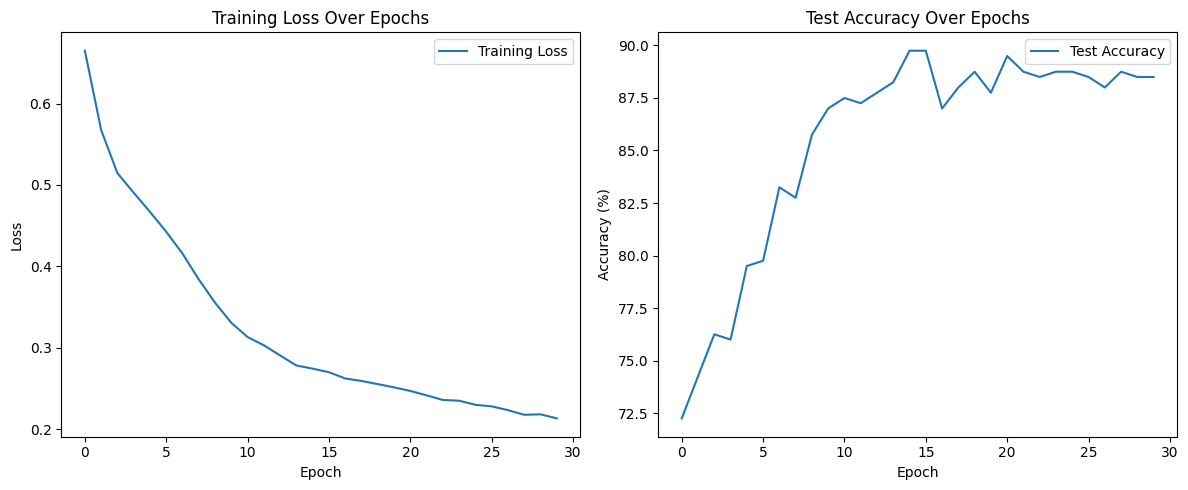

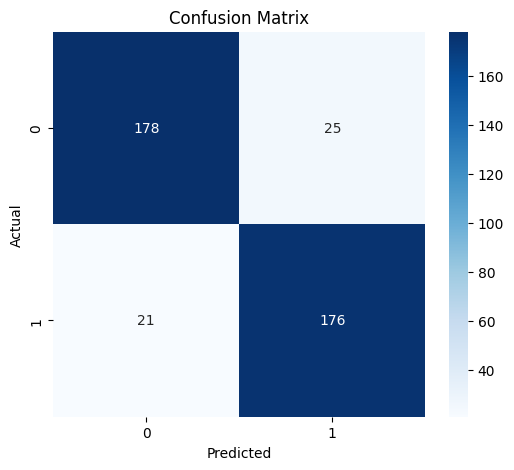

In [26]:
# 14. 시각화
plt.figure(figsize=(12, 5))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# 15. 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()